라이브러리

In [2]:
import pandas as pd
import numpy as np
from keras.utils import *
from sklearn.preprocessing import *
from keras import backend as K
from keras.models import load_model
from keras.layers import LSTM, Dense, concatenate, Input
from sklearn.ensemble import GradientBoostingRegressor
from keras.models import Model
from keras.models import Sequential
import matplotlib.pyplot as plt
from scipy.spatial.distance import euclidean, cosine, correlation
from sklearn.metrics import mean_squared_error, mean_absolute_error, pairwise_distances
from sklearn.metrics import r2_score
import matplotlib.font_manager as fm
from matplotlib.dates import DateFormatter
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

데이터셋 설정

In [3]:
power = pd.read_csv("E:/kimwoojae/Research/DO Regressor/dataset/powerconsumption.csv")
power['Datetime'] = pd.to_datetime(power['Datetime'], format='%m/%d/%Y %H:%M', errors='raise')
power.describe()
power.set_index('Datetime', inplace=True)


In [4]:
start_date = '2017-01-01'
end_date = '2017-11-30'
power_test = power.loc[start_date:end_date]

In [5]:
start_date = '2017-12-01'
end_date = '2017-12-30'
power_validation= power.loc[start_date:end_date]

In [6]:
power_test_X = power_test[['Temperature','Humidity','WindSpeed','GeneralDiffuseFlows','DiffuseFlows','PowerConsumption_Zone1']]
power_test_y = power_test[['PowerConsumption_Zone1']]

In [7]:
power_validation_X = power_validation[['Temperature','Humidity','WindSpeed','GeneralDiffuseFlows','DiffuseFlows','PowerConsumption_Zone1']]
power_validation_y = power_validation[['PowerConsumption_Zone1']]

In [8]:
power_test_X_chunks = []
power_test_y_chunks = []

for i in range(0, len(power_test_X) - 35):
    power_test_X_chunks.append(np.array(power_test_X.iloc[i:i+36].values, dtype=np.float64))
power_test_X_chunks = np.array(power_test_X_chunks, dtype=np.float64)

for i in range(0, len(power_test_y) - 35):
    power_test_y_chunks.append(np.array(power_test_y.iloc[i:i+36].values, dtype=np.float64))
power_test_y_chunks = np.array(power_test_y_chunks, dtype=np.float64)

In [9]:
power_validation_X_chunks = []
power_validation_y_chunks = []

for i in range(0, len(power_validation_X) - 35):
    power_validation_X_chunks.append(np.array(power_validation_X.iloc[i:i+36].values, dtype=np.float64))
power_validation_X_chunks = np.array(power_validation_X_chunks, dtype=np.float64)

for i in range(0, len(power_validation_y) - 35):
    power_validation_y_chunks.append(np.array(power_validation_y.iloc[i:i+36].values, dtype=np.float64))
power_validation_y_chunks = np.array(power_validation_y_chunks, dtype=np.float64)

In [10]:
# shape확인
nCar = power_test_X_chunks.shape[0] # 데이터 개수
nVar = power_test_X_chunks.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = power_test_y_chunks.shape[0] # 데이터 개수
nVar = power_test_y_chunks.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = power_validation_X_chunks.shape[0] # 데이터 개수
nVar = power_validation_X_chunks.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = power_validation_y_chunks.shape[0] # 데이터 개수
nVar = power_validation_y_chunks.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar: 48061 nVar: 6
nCar: 48061 nVar: 36
nCar: 4285 nVar: 6
nCar: 4285 nVar: 36


In [11]:
power_test_X_chunks_crop = power_test_X_chunks[:-36]
power_test_y_chunks_crop = power_test_y_chunks[36:]

power_validation_X_chunks_crop = power_validation_X_chunks[:-36]
power_validation_y_chunks_crop = power_validation_y_chunks[36:]

In [12]:
# shape확인
nCar = power_test_X_chunks_crop.shape[0] # 데이터 개수
nVar = power_test_X_chunks_crop.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = power_test_y_chunks_crop.shape[0] # 데이터 개수
nVar = power_test_y_chunks_crop.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = power_validation_X_chunks_crop.shape[0] # 데이터 개수
nVar = power_validation_X_chunks_crop.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = power_validation_y_chunks_crop.shape[0] # 데이터 개수
nVar = power_validation_y_chunks_crop.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar: 48025 nVar: 6
nCar: 48025 nVar: 36
nCar: 4249 nVar: 6
nCar: 4249 nVar: 36


In [13]:
# r_squared 평가 함수
def r_squared(y_true, y_pred):
    ss_res = K.sum(K.square(y_true - y_pred))
    ss_tot = K.sum(K.square(y_true - K.mean(y_true)))
    return (1 - ss_res/(ss_tot + K.epsilon()))

In [14]:
# LSTM 모델 생성
model = Sequential()
model.add(LSTM(128, input_shape=(36, 6), return_sequences=True))
model.add(LSTM(64, return_sequences=True))
model.add(LSTM(32))
model.add(Dense(36, activation='linear'))
 
model.summary()

# mae와 r_squared 평가함수 추가.
model.compile(optimizer='adam', loss='mse', metrics=['mae', r_squared])


checkpoint = ModelCheckpoint('powerTest_best.h5', monitor='val_loss', save_best_only=True)
early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1)

    # ModelCheckpoint : 검증 손실이 낮아진 경우에 최적의 모델을 저장
# EarlyStopping : 검증 손실이 일정 기간동안 향상되지 않으면 학습을 조기 종료
# ReduceLROnPlateau : 검증 손실이 개선되지 않으면 학습률을 조정하는 등의 동작 수행.


hist = model.fit(power_test_X_chunks_crop, power_test_y_chunks_crop, epochs = 1000, batch_size = 32, validation_data=(power_validation_X_chunks_crop, power_validation_y_chunks_crop), callbacks=[checkpoint, early_stop, reduce_lr])
model.save('powerTest.h5')

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 36, 128)           69120     
                                                                 
 lstm_4 (LSTM)               (None, 36, 64)            49408     
                                                                 
 lstm_5 (LSTM)               (None, 32)                12416     
                                                                 
 dense_1 (Dense)             (None, 36)                1188      
                                                                 
Total params: 132,132
Trainable params: 132,132
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1000
1501/1501 [==============================] - 60s 36ms/step - loss: 1115399680.0000 - mae: 32627.4805 - r_squared: -21.8010 - val_loss: 881226112.0000 - val_mae: 29038.

In [14]:
model = load_model('powerTest.h5', custom_objects={'r_squared': r_squared})

[[ 0.0918166   0.03779054  0.05783876 ... -0.04217373  0.03021766
  -0.08272319]
 [ 0.09153428  0.01767237  0.0251885  ... -0.09290086  0.02695993
  -0.03346599]
 [ 0.06329321 -0.07235872  0.09515407 ...  0.0123843  -0.10551575
  -0.062251  ]
 [ 0.05047003 -0.03552328 -0.00236058 ... -0.08366624  0.07342603
  -0.00458351]
 [-0.0629211   0.09307569  0.02889215 ... -0.05501233  0.09419396
  -0.10586487]
 [-0.00556093  0.05667125  0.03613939 ...  0.0751301  -0.06466796
  -0.09584593]]


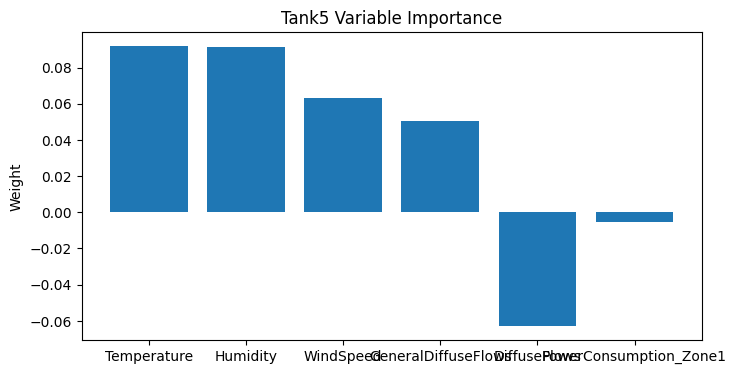

In [15]:
# 가중치를 통해 변수 중요도 획득
weights = model.layers[0].get_weights()[0]
print(weights)


# 변수 중요도 시각화
fig, ax = plt.subplots(figsize=(8, 4))
ax.bar(range(6), weights[:, 0])
ax.set_xticks(range(6))
ax.set_xticklabels(['Temperature','Humidity','WindSpeed','GeneralDiffuseFlows','DiffuseFlows','PowerConsumption_Zone1'])
ax.set_ylabel('Weight')
ax.set_title('Tank5 Variable Importance')
plt.show()

In [27]:
# 모델 평가 함수
def grapeNEva(X_test_shape, y_test, y_test2, y_test_shape):
    X_pred = model.predict(X_test_shape)
    X_pred = np.asarray(X_pred, dtype=np.float64)
    X_pred = X_pred.reshape((-1))
    print(len(X_pred))


    # 그래프 생성
    plt.figure(figsize=(15, 7))
    plt.plot(y_test.index, y_test, label='power')  # x축에 년월일, y축에 값
    plt.plot(y_test.index, X_pred, label='prediction')  # x축에 년월일, y축에 시분
    
    plt.xlabel('date')
    plt.ylabel('power')
    plt.title('test')
    plt.legend(['power','prediction'])
    plt.show()

     # 그래프 생성
    plt.figure(figsize=(15, 7))
    plt.plot(y_test.index, y_test2[['Temperature']], label='Temperature')  # x축에 년월일, y축에 시분
    plt.plot(y_test.index, y_test2[['Humidity']], label='Humidity')  # x축에 년월일, y축에 시분
    plt.plot(y_test.index, y_test2[['WindSpeed']], label='WindSpeed')  # x축에 년월일, y축에 시분


    plt.xlabel('date')
    plt.ylabel('power')
    plt.title('test')
    plt.legend(['Temperature','Humidity','WindSpeed'])
    plt.show()
    
         # 그래프 생성
    plt.figure(figsize=(15, 7))
    plt.plot(y_test.index, y_test2[['GeneralDiffuseFlows']], label='GeneralDiffuseFlows')  # x축에 년월일, y축에 시분
    plt.plot(y_test.index, y_test2[['DiffuseFlows']], label='DiffuseFlows')  # x축에 년월일, y축에 시분


    plt.xlabel('date')
    plt.ylabel('power')
    plt.title('test')
    plt.legend(['GeneralDiffuseFlows','DiffuseFlows'])
    plt.show()

    # 평가 생성
    result = model.evaluate(X_test_shape, y_test_shape)
    print("MSE // MAE // R-squared ", result)

In [28]:
y_test2 = power_validation_X[['Temperature','Humidity','WindSpeed','GeneralDiffuseFlows','DiffuseFlows','PowerConsumption_Zone1']]


In [29]:
X_test = power_validation_X.loc['2017-12-01 00:00':'2017-12-30 17:50']

X_test_reshape = np.asarray(X_test, dtype=np.float64)
X_test_reshape = X_test_reshape.reshape((-1, 36, 6))

# shape확인
nCar = X_test_reshape.shape[0] # 데이터 개수
nVar = X_test_reshape.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar: 119 nVar: 36


In [30]:
y_test = power_validation_y.loc['2017-12-01 06:00':'2017-12-30 23:50']
y_test2 = y_test2.loc['2017-12-01 06:00':'2017-12-30 23:50']

y_test_reshape = np.asarray(y_test, dtype=np.float64)
y_test_reshape = y_test_reshape.reshape((-1, 36, 1))

nCar = y_test.shape[0] # 데이터 개수
nVar = y_test.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = y_test_reshape.shape[0] # 데이터 개수
nVar = y_test_reshape.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar: 4284 nVar: 1
nCar: 119 nVar: 36


4/4 [==============================] - 0s 14ms/step
4284


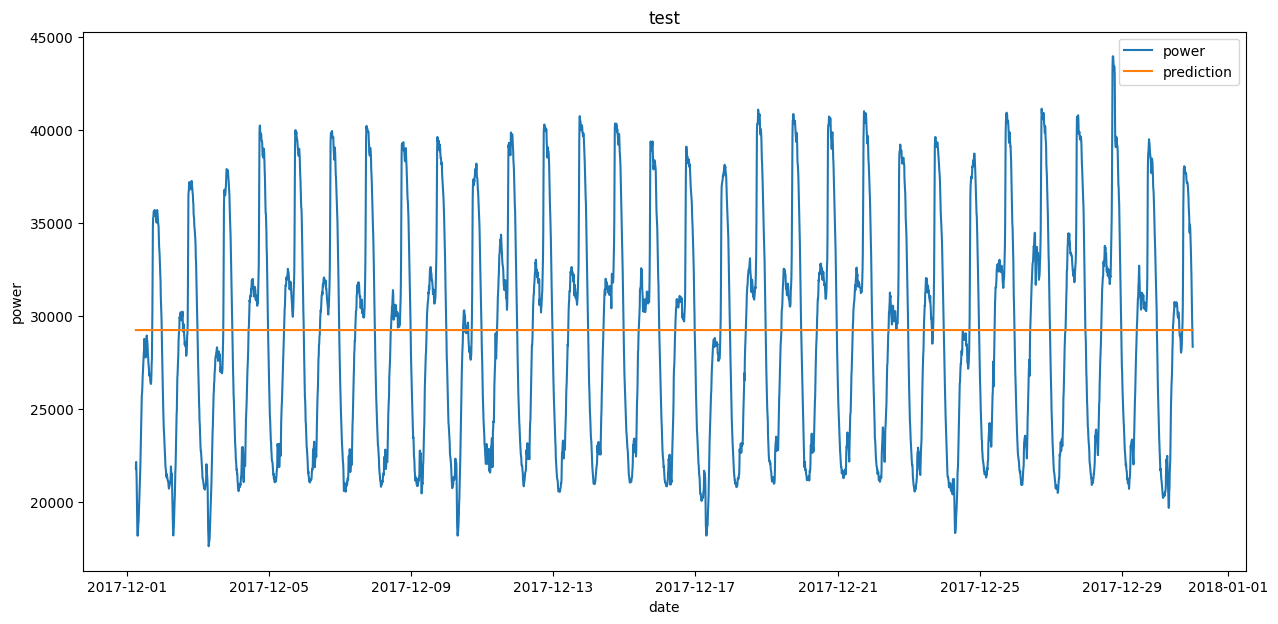

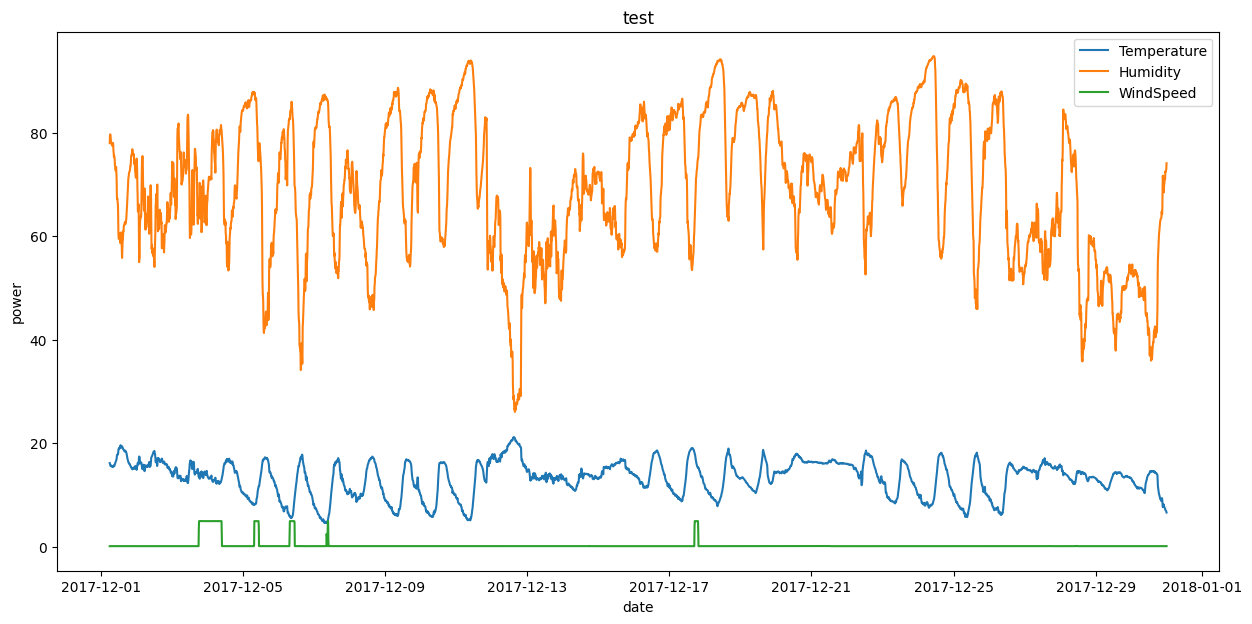

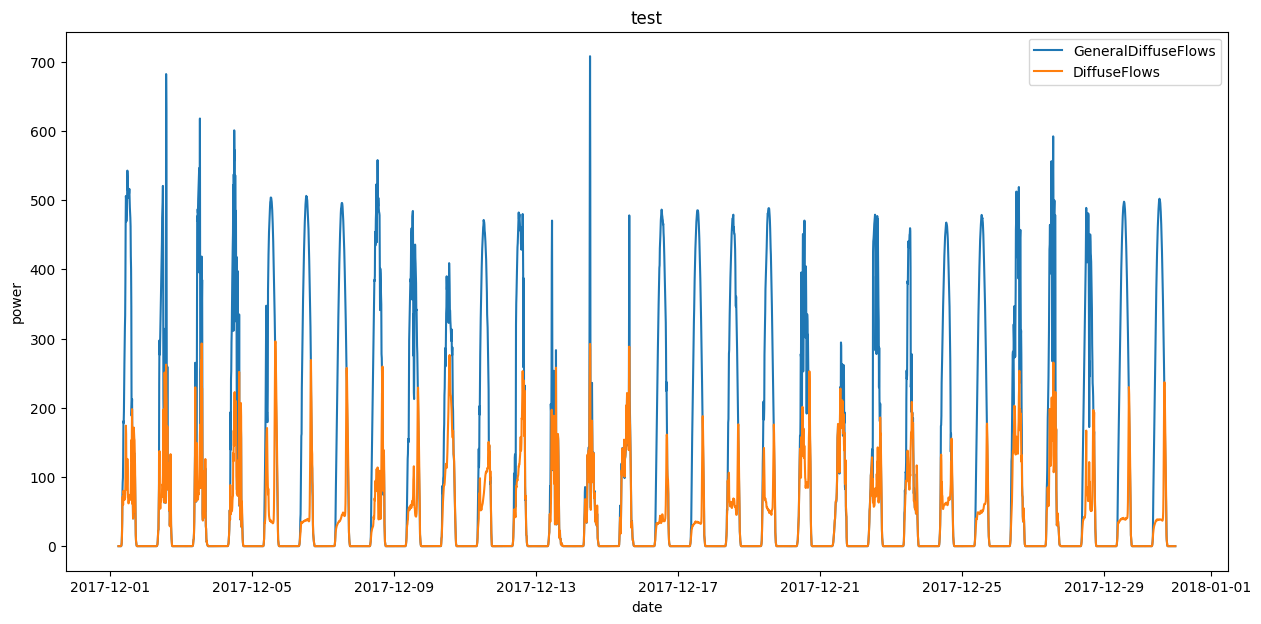

4/4 [==============================] - 0s 15ms/step - loss: 38131320.0000 - mae: 5259.4463 - r_squared: -0.0077
MSE // MAE // R-squared  [38131320.0, 5259.4462890625, -0.0077117979526519775]


In [31]:
grapeNEva(X_test_reshape, y_test,y_test2, y_test_reshape)

nCar: 7 nVar: 36
nCar: 252 nVar: 1
nCar: 7 nVar: 36
1/1 [==============================] - 0s 33ms/step
252


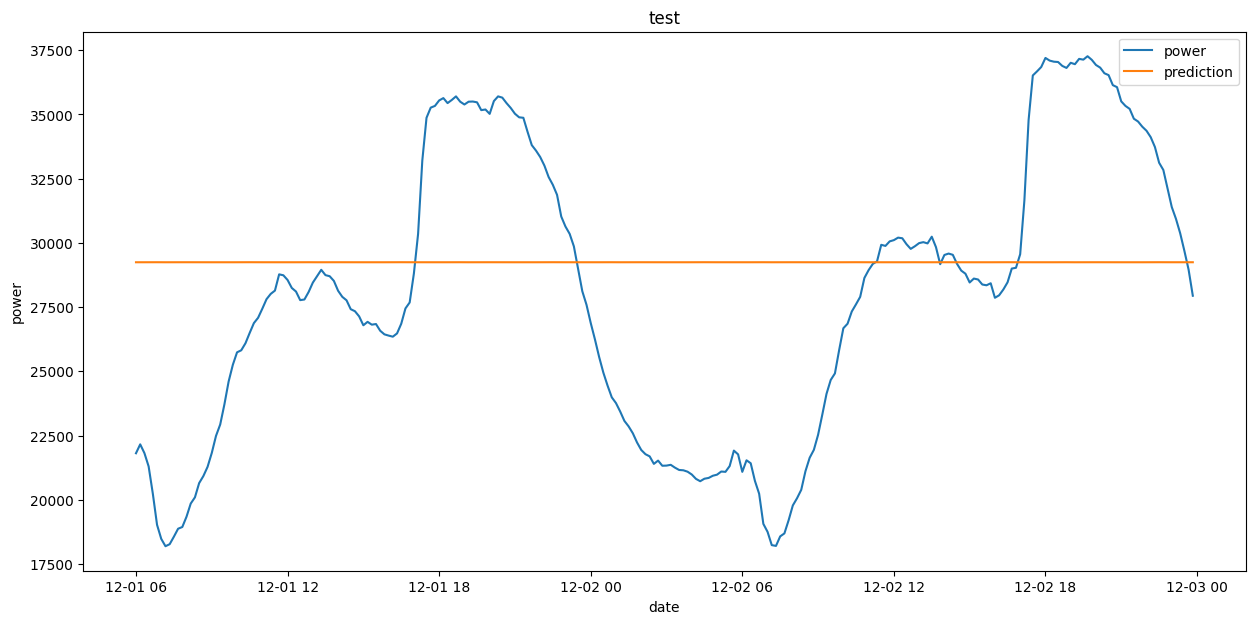

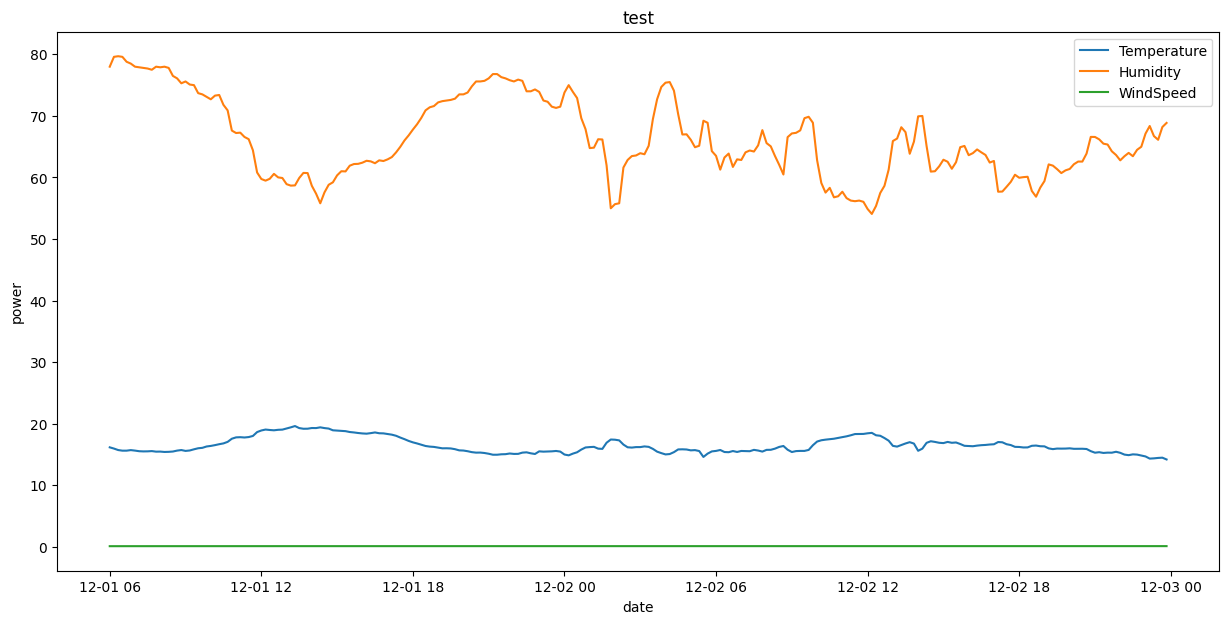

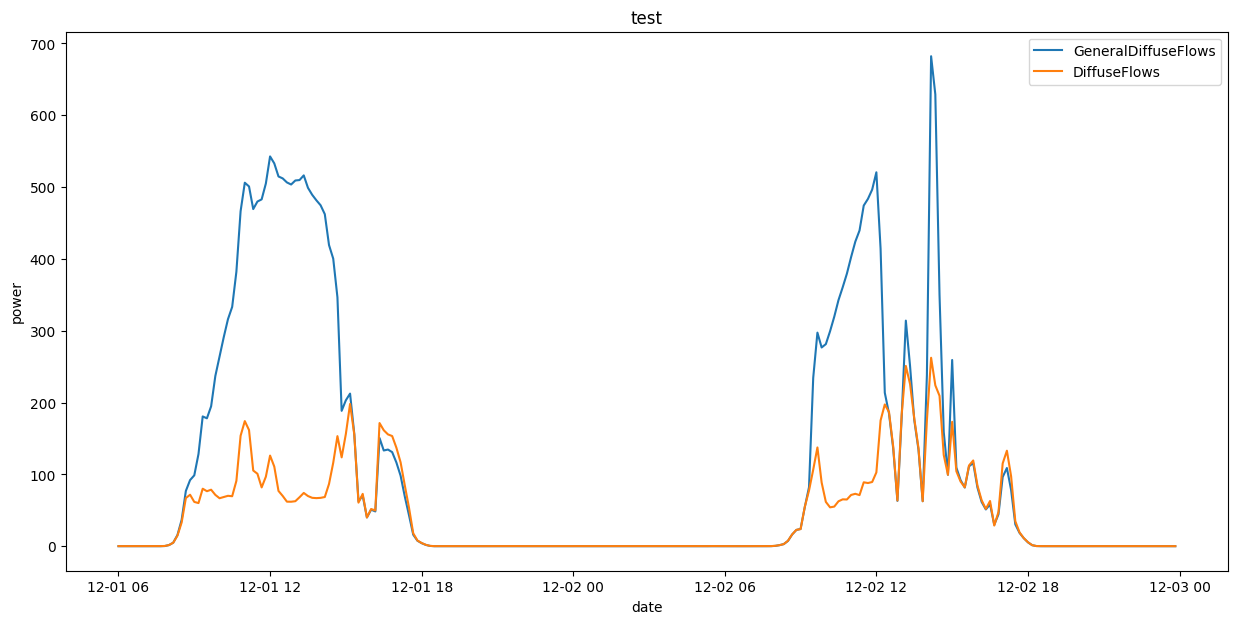

1/1 [==============================] - 0s 40ms/step - loss: 32471684.0000 - mae: 4688.6318 - r_squared: -0.0516
MSE // MAE // R-squared  [32471684.0, 4688.6318359375, -0.05160212516784668]


In [32]:
X_test = power_validation_X.loc['2017-12-01 00:00':'2017-12-02 17:50']

X_test_reshape = np.asarray(X_test, dtype=np.float64)
X_test_reshape = X_test_reshape.reshape((-1, 36, 6))

# shape확인
nCar = X_test_reshape.shape[0] # 데이터 개수
nVar = X_test_reshape.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

y_test = power_validation_y.loc['2017-12-01 06:00':'2017-12-02 23:50']
y_test2 = y_test2.loc['2017-12-01 06:00':'2017-12-02 23:50']

y_test_reshape = np.asarray(y_test, dtype=np.float64)
y_test_reshape = y_test_reshape.reshape((-1, 36, 1))

nCar = y_test.shape[0] # 데이터 개수
nVar = y_test.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = y_test_reshape.shape[0] # 데이터 개수
nVar = y_test_reshape.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

grapeNEva(X_test_reshape, y_test,y_test2, y_test_reshape)